In [1]:
# Instalasi Library yang dibutuhkan
!pip install Sastrawi
!pip install nltk
!pip install gensim

In [3]:
# Preprocessing data teks
import pandas as pd
import re
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

file_data_mentah = "data_ulasan.csv"
file_kamus_slang = "kamus_slang.csv"
output_file_final_preprocessing = "data_akhir.csv"

df = pd.read_csv(file_data_mentah, sep=';', on_bad_lines='skip')

def clean_text_cleansing(text):
    if isinstance(text, str):
        text = text.strip()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text)
    return text

df['Content'] = df['Content'].astype(str).apply(clean_text_cleansing)
df.drop_duplicates(subset=['Content'], inplace=True)
df.dropna(subset=['Content'], inplace=True)

def clean_text_casefolding(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.strip()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
    return text

df['Content'] = df['Content'].astype(str).apply(clean_text_casefolding)

df_slang = pd.read_csv(file_kamus_slang, sep=';')
slang_dict = dict(zip(df_slang['slang'], df_slang['formal']))

def convert_slangword(text):
    if pd.isna(text):
        return ""
    words = text.split()
    normalized_words = [slang_dict.get(word.lower(), word) for word in words]
    return ' '.join(normalized_words)

df['Content'] = df['Content'].apply(convert_slangword)

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    if pd.isna(text):
        return ""
    return stemmer.stem(str(text))

df['Content'] = df['Content'].apply(stem_text)

list_stopwords = stopwords.words('indonesian')
list_stopwords.append('nya')
if 'tidak' in list_stopwords:
    list_stopwords.remove('tidak')

def remove_stopwords(text):
    if pd.isna(text):
        return ""
    words = word_tokenize(str(text))
    filtered_words = [word for word in words if word.lower() not in list_stopwords]
    return ' '.join(filtered_words)

df['Content'] = df['Content'].astype(str).apply(remove_stopwords)
def handle_negation(tokens):
    new_tokens = []
    i = 0
    while i < len(tokens):
        if tokens[i] == 'tidak' and i + 1 < len(tokens):
            new_tokens.append(tokens[i] + '_' + tokens[i+1])
            i += 2
        else:
            new_tokens.append(tokens[i])
            i += 1
    return new_tokens

def tokenize_text_final(text):
    if pd.isna(text):
        return []
    return word_tokenize(str(text))

df['Content'] = df['Content'].apply(tokenize_text_final)

df.to_csv(output_file_final_preprocessing, index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
# Pelatihan Model Word2Vec
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import ast
import os
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

file_data = "data_akhir.csv"
df = pd.read_csv(file_data, sep=',', on_bad_lines='skip')

df['Content'] = df['Content'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

label_mapping = {
    'Negatif': 0,
    'Positif': 1,
}
df['Sentiment_Numeric'] = df['Label'].map(label_mapping)

df.dropna(subset=['Content', 'Sentiment_Numeric'], inplace=True)

X_tokens = df['Content'].tolist()
y_labels = df['Sentiment_Numeric'].tolist()

print(f"Jumlah dokumen (ulasan) untuk pelatihan Word2Vec: {len(X_tokens)}")
print(f"Contoh ulasan tokenized pertama: {X_tokens[0]}")
print(f"Contoh label sentimen pertama (numerik): {y_labels[0]}")

model_w2v_from_scratch = Word2Vec(
    sentences=X_tokens,
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,
    workers=4
)

model_w2v_from_scratch.train(X_tokens, total_examples=model_w2v_from_scratch.corpus_count, epochs=40)
model_w2v_from_scratch.save("word2vec_from_scratch_model.model")
joblib.dump(model_w2v_from_scratch, 'word2vec_model.pkl')


def get_document_vector(word2vec_model, doc_tokens):
    doc_vector = np.zeros(word2vec_model.wv.vector_size)
    word_count = 0
    for word in doc_tokens:
        if word in word2vec_model.wv:
            doc_vector += word2vec_model.wv[word]
            word_count += 1

    if word_count > 0:
        return doc_vector / word_count
    return doc_vector

X_features_from_scratch = np.array([get_document_vector(model_w2v_from_scratch, tokens) for tokens in X_tokens])

print(f"Bentuk data fitur (X_features_from_scratch): {X_features_from_scratch.shape}")
print(f"Contoh vektor ulasan pertama (5 elemen): {X_features_from_scratch[0][:5]}...")

Jumlah dokumen (ulasan) untuk pelatihan Word2Vec: 328
Contoh ulasan tokenized pertama: ['jelek', 'tolong', 'duit', 'gue', 'ribu', 'ngendap', 'ribu', 'gue', 'gue', 'kerja', 'gaji', 'umr', 'tolong', 'aplikasi', 'kali', 'benah']
Contoh label sentimen pertama (numerik): 0
Bentuk data fitur (X_features_from_scratch): (328, 100)
Contoh vektor ulasan pertama (5 elemen): [-0.18774036  0.18697347 -0.12108774  0.04146808  0.15321679]...


In [5]:
# Mengatasi ketidakseimbangan Kleas dengan SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

print(f"Distribusi kelas sebelum SMOTE: {Counter(y_labels)}")
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_features_from_scratch, y_labels)

print(f"Distribusi kelas setelah SMOTE: {Counter(y_resampled)}")

Distribusi kelas sebelum SMOTE: Counter({0: 282, 1: 46})
Distribusi kelas setelah SMOTE: Counter({0: 282, 1: 282})


In [6]:
# Pelatihan & Evaluasi Model Klasifikasi SVM
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, 'svm_model.pkl')

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n1. Akurasi Model: {accuracy:.4f}")
print("\n2. Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negatif (0)', 'Positif (1)']))



1. Akurasi Model: 0.8142

2. Classification Report:
              precision    recall  f1-score   support

 Negatif (0)       0.88      0.74      0.80        57
 Positif (1)       0.77      0.89      0.83        56

    accuracy                           0.81       113
   macro avg       0.82      0.81      0.81       113
weighted avg       0.82      0.81      0.81       113



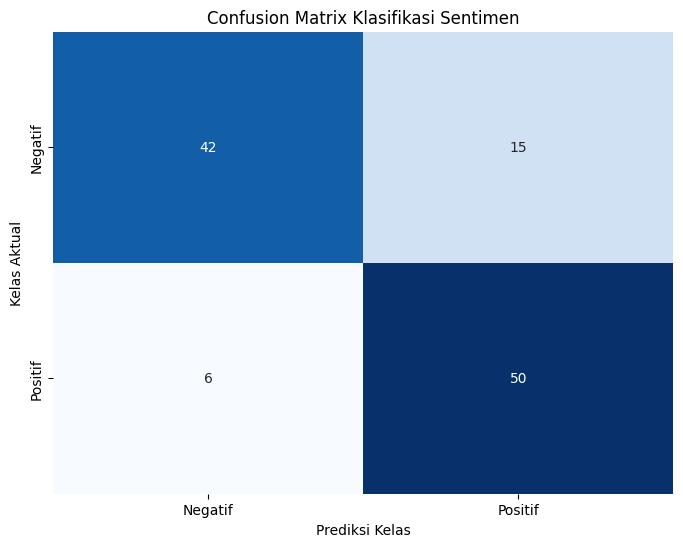

In [7]:
# Visualisasi Hasil dengan Confusion Matrix
from sklearn.metrics import confusion_matrix

y_pred = svm_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ['Negatif', 'Positif']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Prediksi Kelas')
plt.ylabel('Kelas Aktual')
plt.title('Confusion Matrix Klasifikasi Sentimen')
plt.show()

In [8]:
# Validasi Model dengan K-Fold Cross Validation
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

if not isinstance(y_resampled, np.ndarray):
    y_resampled = np.array(y_resampled)
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

svm_model_cv = SVC(kernel='linear', C=1, max_iter=150, random_state=42)
results_per_fold = defaultdict(list)

print(f"Memulai Pengujian {n_splits}-Fold Cross Validation pada data yang sudah di-SMOTE...")
fold_count = 1
for train_index, test_index in kf.split(X_resampled, y_resampled):
    print(f"--- Fold {fold_count} ---")
    X_train_fold, X_test_fold = X_resampled[train_index], X_resampled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]

    svm_model_cv.fit(X_train_fold, y_train_fold)
    y_pred_fold = svm_model_cv.predict(X_test_fold)

    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, average='binary', pos_label=1, zero_division=0)
    recall = recall_score(y_test_fold, y_pred_fold, average='binary', pos_label=1, zero_division=0)
    f1 = f1_score(y_test_fold, y_pred_fold, average='binary', pos_label=1, zero_division=0)

    results_per_fold['Accuracy'].append(accuracy)
    results_per_fold['Precision'].append(precision)
    results_per_fold['Recall'].append(recall)
    results_per_fold['F1-Score'].append(f1)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    fold_count += 1

print(f"\n--- Hasil Rata-rata dari {n_splits}-Fold Cross Validation ---")
print("N-Fold\tAccuracy\tPrecision\tRecall\tF1-Score")
for i in range(n_splits):
    print(f"{i+1}\t{results_per_fold['Accuracy'][i]:.4f}\t{results_per_fold['Precision'][i]:.4f}\t{results_per_fold['Recall'][i]:.4f}\t{results_per_fold['F1-Score'][i]:.4f}")

mean_accuracy = np.mean(results_per_fold['Accuracy'])
mean_precision = np.mean(results_per_fold['Precision'])
mean_recall = np.mean(results_per_fold['Recall'])
mean_f1 = np.mean(results_per_fold['F1-Score'])

print(f"Mean\t{mean_accuracy:.4f}\t{mean_precision:.4f}\t{mean_recall:.4f}\t{mean_f1:.4f}")


Memulai Pengujian 10-Fold Cross Validation pada data yang sudah di-SMOTE...
--- Fold 1 ---
  Accuracy: 0.8246
  Precision: 0.7812
  Recall: 0.8929
  F1-Score: 0.8333
--- Fold 2 ---
  Accuracy: 0.9123
  Precision: 0.8966
  Recall: 0.9286
  F1-Score: 0.9123
--- Fold 3 ---
  Accuracy: 0.8070
  Precision: 0.8214
  Recall: 0.7931
  F1-Score: 0.8070
--- Fold 4 ---
  Accuracy: 0.8596
  Precision: 0.8387
  Recall: 0.8966
  F1-Score: 0.8667
--- Fold 5 ---
  Accuracy: 0.8571
  Precision: 0.8333
  Recall: 0.8929
  F1-Score: 0.8621
--- Fold 6 ---
  Accuracy: 0.7857
  Precision: 0.7667
  Recall: 0.8214
  F1-Score: 0.7931
--- Fold 7 ---
  Accuracy: 0.8214
  Precision: 0.7812
  Recall: 0.8929
  F1-Score: 0.8333
--- Fold 8 ---
  Accuracy: 0.8393
  Precision: 0.8276
  Recall: 0.8571
  F1-Score: 0.8421
--- Fold 9 ---
  Accuracy: 0.8929
  Precision: 0.8438
  Recall: 0.9643
  F1-Score: 0.9000
--- Fold 10 ---
  Accuracy: 0.8929
  Precision: 0.8438
  Recall: 0.9643
  F1-Score: 0.9000

--- Hasil Rata-rata da

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-

/tmp/ipython-input-2080227371.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


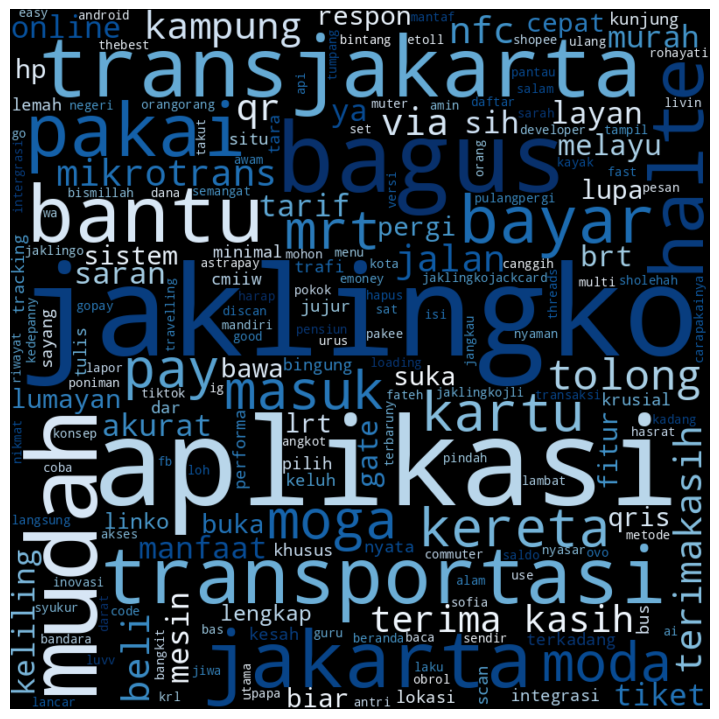


Frekuensi Kata Sentimen Positif (Top 20):
jaklingko: 20
aplikasi: 19
bagus: 11
mudah: 11
transjakarta: 8
transportasi: 7
jakarta: 7
bantu: 7
pakai: 6
halte: 6
bayar: 6
moda: 4
kartu: 4
moga: 4
masuk: 4
mrt: 4
pay: 4
kereta: 4
tolong: 4
beli: 3


In [9]:
# Visualisasi Kata dengan Word Cloud (Sentimen Positif)
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast
import os
from collections import Counter

output_file_final_preprocessing = "data_akhir.csv"
df_wordcloud = pd.read_csv(output_file_final_preprocessing, sep=',')

df_wordcloud['Content'] = df_wordcloud['Content'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

positive_reviews = df_wordcloud[df_wordcloud['Label'] == 'Positif']['Content']

all_positive_words = []
for tokens in positive_reviews:
    if isinstance(tokens, list) and tokens:
        all_positive_words.extend(tokens)

positive_word_counts = Counter(all_positive_words)

positive_text_for_wc = " ".join(all_positive_words)

wordcloud_positive = WordCloud(width=800, height=800, background_color='black',
                               colormap='Blues', min_font_size=10, max_words=200).generate(positive_text_for_wc)

plt.figure(figsize=(10, 7), frameon=False)
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)

ax.imshow(wordcloud_positive, interpolation='bilinear')
plt.tight_layout()
plt.savefig('wordcloud_positif_noborder.png', bbox_inches='tight', pad_inches=0)
plt.show()

print("\nFrekuensi Kata Sentimen Positif (Top 20):")
for word, count in positive_word_counts.most_common(20):
    print(f"{word}: {count}")

/tmp/ipython-input-1386546533.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


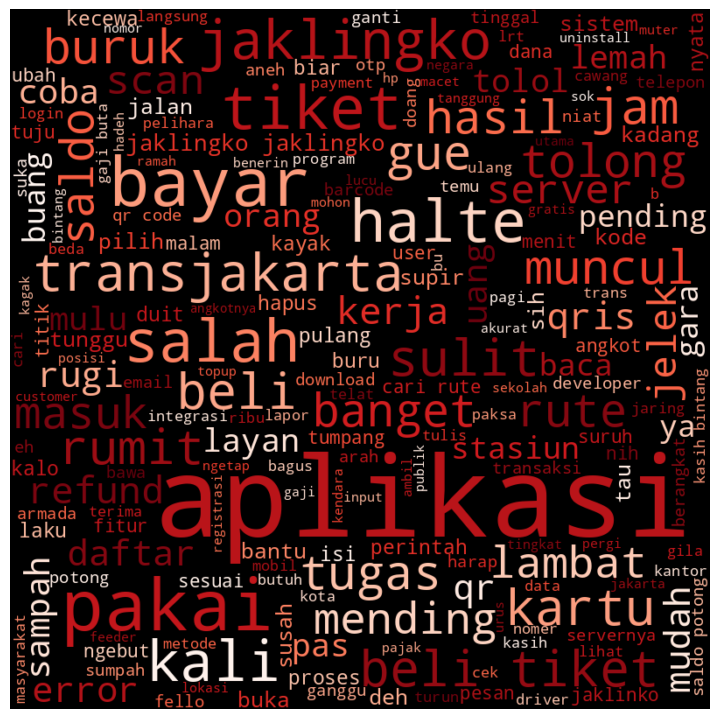


Frekuensi Kata Sentimen Negatif (Top 20):
aplikasi: 194
tiket: 60
pakai: 51
beli: 48
jaklingko: 47
bayar: 46
halte: 34
salah: 34
kali: 31
transjakarta: 26
sulit: 25
rute: 25
saldo: 24
kartu: 24
jam: 23
rumit: 22
gue: 21
muncul: 21
buruk: 21
tugas: 21


In [10]:
# Visualisasi Kata dengan Word Cloud (Sentimen Negatif)
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast
import os
from collections import Counter

output_file_final_preprocessing = "data_akhir.csv"
df_wordcloud = pd.read_csv(output_file_final_preprocessing, sep=',')
df_wordcloud['Content'] = df_wordcloud['Content'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

negative_reviews = df_wordcloud[df_wordcloud['Label'] == 'Negatif']['Content']

all_negative_words = []
for tokens in negative_reviews:
    if isinstance(tokens, list) and tokens:
        all_negative_words.extend(tokens)

negative_word_counts = Counter(all_negative_words)

negative_text_for_wc = " ".join(all_negative_words)

wordcloud_negative = WordCloud(width=800, height=800, background_color='black',
                               colormap='Reds', min_font_size=10, max_words=200).generate(negative_text_for_wc)

plt.figure(figsize=(10, 7), frameon=False)
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)

ax.imshow(wordcloud_negative, interpolation='bilinear')
plt.tight_layout()
plt.savefig('wordcloud_negatif_noborder.png', bbox_inches='tight', pad_inches=0)
plt.show()

print("\nFrekuensi Kata Sentimen Negatif (Top 20):")
for word, count in negative_word_counts.most_common(20):
    print(f"{word}: {count}")